# (1)Import

In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) #set for testing purposes, please do not change! 


# (2)Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_chan=1, hidden_dim =64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            self.gen_block(z_dim, hidden_dim*4),
            self.gen_block(hidden_dim*4, hidden_dim*2, kernel_size=4, stride=1),
            self.gen_block(hidden_dim*2, hidden_dim),
            self.gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )
    def gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace =True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )
    def unsqueeze_noise(self, noise):
        return noise.view(len(noise), self.z_dim, 1, 1)
   
    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

# (3)Discriminator

In [ ]:
class Discriminator(nn.Module):
  def __init__ (self, im_chan=1, hidden_dim = 16):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        self.disc_block(im_chan, hidden_dim),
        self.disc_block(hidden_dim, hidden_dim *2),
        self.disc_block(hidden_dim *2, 1, final_layer =True ),
    )

  def disc_block(self, in_channel, out_channel, kernel_size =4, stride=2, final_layer =False):
    if not final_layer:
      return nn.Sequential(
          nn.Conv2d(in_channel,out_channel,kernel_size,stride),
          nn.BatchNorm2d(out_channel),
          nn.LeakyReLU(0.2, inplace = True)
      )
    else: # Final Layer
      return nn.Sequential(
          nn.Conv2d(in_channel,out_channel,kernel_size, stride)
      )

  def forward(self, images):
    disc_pred = self.disc(images)
    return disc_pred.view(len(disc_pred),-1)

# (4)Noise 생성

In [ ]:
def get_noise(n_samples, z_dim, device ='cpu'):
  return torch.randn(n_samples, z_dim, device=device)

# (5)Class 처리

In [ ]:
# One-hot vector 생성
import torch.nn.functional as F
def get_one_hot_labels(labels,n_classes):
    return F.one_hot(labels,n_classes)

#Latent vector 와 one-hot vectordml concat
def combine_vectors(x,y):
    combined = torch.cat((x.float(),y.float()),1)
    return combined

### 데이터로딩

#### 초기화

In [ ]:
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = 'cuda'
criterion = nn.BCEWithLogitsLoss()
mnist_shape = (1, 28, 28)
n_classes = 10

In [ ]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,)),                                 
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# (6)기타

# optimizer

In [ ]:
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] +n_classes

    return generator_input_dim,discriminator_im_chan

In [ ]:
generator_input_dim , discriminator_im_chan = get_input_dimensions(z_dim,mnist_shape,n_classes)

gen = Generator(z_dim = generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan = discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(),lr = lr)


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.ConvTranspose2d):
        torch.nn.init.normal(m.weight, 0.0,0.02)
    if isinstance(m,nn.BatchNorm2d):
        torch.nn.init.normal(m.weight, 0.0,0.02)
        torch.nn.init.constant_(m.bias,0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  del sys.path[0]


### image display

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1,28,28), nrow=5, show=True):
  image_tensor = (image_tensor + 1) / 2
  image_unflat = image_tensor.detach().cpu()
  image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
  plt.imshow(image_grid.permute(1,2,0).squeeze())
  if show:
    plt.show()

# (7)Training

Step 500:Generator loss: 0.704550112247467,Discriminator loss: 0.6894457008838654


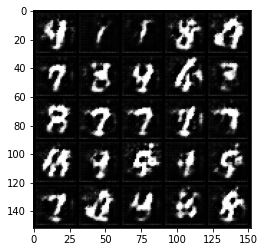

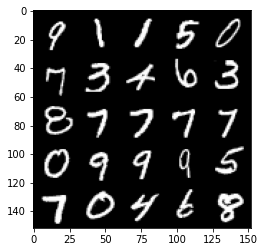

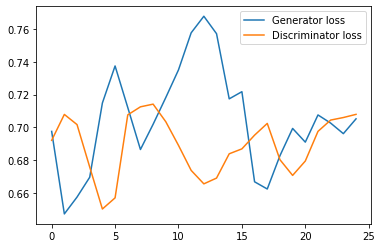

Step 1000:Generator loss: 0.7144339954853058,Discriminator loss: 0.6870668656826019


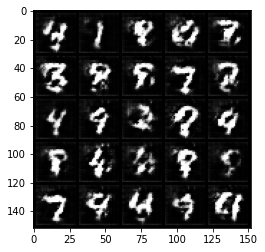

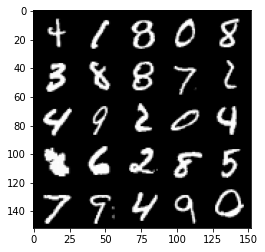

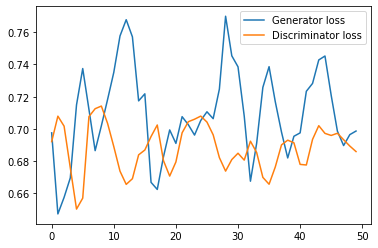

Step 1500:Generator loss: 0.6949585551023483,Discriminator loss: 0.6961730105876922


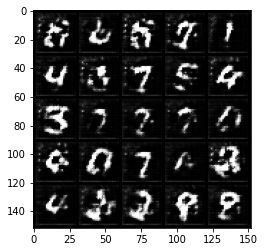

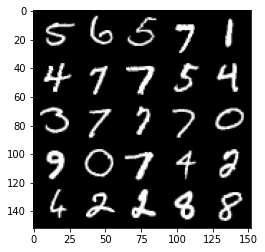

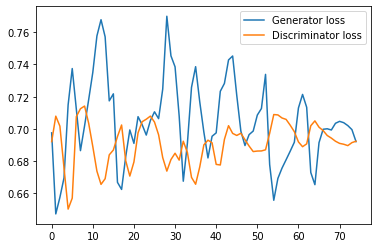

Step 2000:Generator loss: 0.6947388027906418,Discriminator loss: 0.6920788049697876


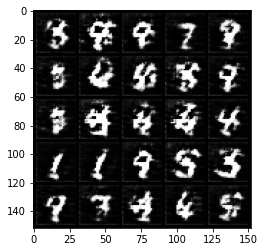

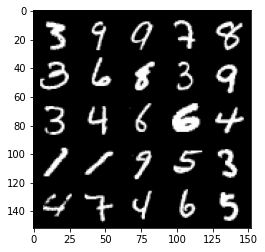

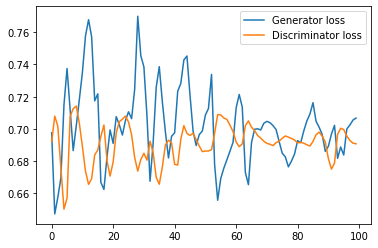

In [17]:
cur_step = 0
generator_losses = []
discriminator_losses = []
n_epochs = 5
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs): # 기존에 100 epoch 수행
  for real, labels in tqdm(dataloader):
    cur_batch_size = len(real)
    real = real.to(device)
    labels = labels.to(device)
    # update disc
    one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
    
    image_one_hot_labels = one_hot_labels[:,:,None,None]
    image_one_hot_labels = image_one_hot_labels.repeat(1,1,mnist_shape[1],mnist_shape[2])


    disc_opt.zero_grad()
    fake_noise = get_noise(cur_batch_size, z_dim, device = device) #z

    noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
    fake = gen(noise_and_labels) 

    #discriminator 영상크기에 영향을 미침 영상크기와 똑같은 노이즈를 만들어줌 
    fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)  # G(z/y)
    real_image_and_labels = combine_vectors(real, image_one_hot_labels) # x/y
   
    disc_fake_pred = disc(fake_image_and_labels)# D(G(z/y))

    disc_real_pred = disc(real_image_and_labels)  # D(x/y)

    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss)/2
    disc_loss.backward(retain_graph = True)
    disc_opt.step()

    discriminator_losses += [disc_loss.item()]

    #update gen 
    gen_opt.zero_grad()

    fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)

    disc_fake_pred = disc(fake_image_and_labels) # D(G(z)) /#detach 뺌으로써 미분 사용 
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    gen_loss.backward()
    gen_opt.step()

    generator_losses += [gen_loss.item()]

    #visualize the results
    if cur_step % display_step == 0 and cur_step >0:
        gen_mean = sum(generator_losses[-display_step:])/ display_step
        disc_mean = sum(discriminator_losses[-display_step:])/display_step
        print(f"Step {cur_step}:Generator loss: {gen_mean},Discriminator loss: {disc_mean}")
        show_tensor_images(fake)
        show_tensor_images(real)
        step_bins = 20
        x_axis = sorted([i*step_bins for i in range (len(generator_losses)//step_bins)]* step_bins)
        num_examples = (len(generator_losses)//step_bins) *step_bins
        plt.plot(
            range(num_examples//step_bins),
            torch.Tensor(generator_losses[:num_examples]).view(-1,step_bins).mean(1),
            label ="Generator loss"
        )
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label = "Discriminator loss"
        )
        plt.legend()
        plt.show()
    cur_step += 1
